In [14]:
import pandas as pd
import numpy as np
import datetime as dt
import pylab as pl
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
import seaborn as sns
import itertools
import scipy.stats as scs
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from IPython.display import HTML, display

In [15]:
df = pd.read_csv("YesBank-datadump.csv")

In [16]:
df.columns = df.columns.str.lstrip()

In [17]:
df.columns = df.columns.str.lower()

In [18]:
df.columns = df.columns.str.replace(" ", "_")

In [19]:
df.columns

Index([u'activity_type', u'user_id', u'rm_id', u'user_os', u'viewing_app',
       u'user_groups', u'shared_date', u'shared_time', u'title_of_content',
       u'share_channel', u'viewed', u'time_spent_in_seconds',
       u'last_activity_date', u'last_activity_time'],
      dtype='object')

# EDA & Feature Engineering

In [20]:
df["user_os"].unique()


array(['MAC_OS_X_IPHONE', nan, 'ANDROID4', 'ANDROID6', 'ANDROID_MOBILE',
       'ANDROID5', 'WINDOWS_10', 'WINDOWS_7', 'iOS9_IPHONE', 'MAC_OS_X'], dtype=object)

In [21]:
df.rename(columns={'user_os': 'viewing_device'}, inplace=True)
df["viewing_device"].replace({"WINDOWS_7" : "Laptop/Desktop", "WINDOWS_10" : "Laptop/Desktop", "MAC_OS_X" : "Laptop/Desktop"}, inplace = True)
df["viewing_device"].replace({"ANDROID_MOBILE" : "Phone", "ANDROID6" : "Phone", "ANDROID4" : "Phone", "ANDROID5" : "Phone", "MAC_OS_X_IPHONE" : "Phone", "iOS9_IPHONE" : "Phone", "iOS8_1_IPHONE" : "Phone", "iOS8_3_IPHONE" : "Phone", "iOS9_IPHONE" : "Phone"}, inplace=True)


In [26]:
df.browser.unique()


array(['SAFARI', nan, 'CHROME_MOBILE', 'MOBILE_SAFARI', 'CHROME'], dtype=object)

In [24]:
df.rename(columns={'viewing_app': 'browser'}, inplace=True)
df["browser"].replace({"CHROME45" : "CHROME", "CHROME51" : "CHROME", "CHROME33" : "CHROME", "CHROME30" : "CHROME", "CHROME47" : "CHROME", "CHROME49" : "CHROME", "CHROME42" : "CHROME", "CHROME48" : "CHROME", "CHROME38" : "CHROME", "FIREFOX44" : "FIREFOX", "FIREFOX47" : "FIREFOX", "FIREFOX43" : "FIREFOX", "FIREFOX37" : "FIREFOX", "EDGE12" : "EDGE"}, inplace = True)
df["browser"].replace({"EDGE13" : "EDGE", "EDGE14" : "EDGE", "IE7" : "IE", "IE10" : "IE", "IE11" : "IE", "SAFARI9" : "SAFARI", "APPLE_WEB_KIT" : "SAFARI"}, inplace=True)
df.browser.unique()

array(['SAFARI', nan, 'CHROME_MOBILE', 'MOBILE_SAFARI', 'CHROME'], dtype=object)

In [27]:
df["shared_date"] = pd.to_datetime(df["shared_date"], format="%d-%b-%Y")

In [28]:
df["last_activity_date"] = pd.to_datetime(df["last_activity_date"], format="%d-%b-%Y")

In [31]:
df['weekday'] = df['last_activity_date'].dt.dayofweek
df["weekday_name"] = df['last_activity_date'].dt.weekday_name
df["month"] = df['last_activity_date'].dt.month
df["time_of_day"] = pd.to_datetime(df['last_activity_time'], format='%H:%M').dt.hour
df.time_of_day.unique()

array([19,  9, 20, 21, 22, 11, 18, 17, 16, 15, 14, 13, 12, 10, 23,  8,  2,
        0,  1])

In [32]:
# 1: Night(Midnight to 6 am), 2: Morning(6 am to Noon), 3: Afternoon(Noon to 6 pm), 4: Evening(6 pm to Midnight)
df["time_of_day"].replace({0 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 1}, inplace = True)
df["time_of_day"].replace({6 : 2, 7 : 2, 8 : 2, 9 : 2, 10 : 2, 11 : 2}, inplace = True)
df["time_of_day"].replace({12 : 3, 13 : 3, 14 : 3, 15 : 3, 16 : 3, 17 : 3}, inplace = True)
df["time_of_day"].replace({18 : 4, 19 : 4, 20 : 4, 21 : 4, 22 : 4, 23 : 4,}, inplace = True)
df.time_of_day.unique()

array([4, 2, 3, 1])

In [34]:
df['hour'] = pd.to_datetime(df['last_activity_time'], format='%H:%M').dt.hour

In [35]:
df.viewed.unique()

array([1, 0])

In [36]:
df["time_spent_mins"] = df["time_spent_in_seconds"]/60.

In [37]:
hour_grouped = df.groupby("time_of_day")["time_spent_mins"].sum()

In [38]:
# plot = plt.bar(xrange(0,4),(df.groupby("time_of_day")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,4),["Night", "Morning", "Afternoon", "Evening"])


In [39]:
#sns.distplot(df["time_spent_mins"], color="m")
len(df)

538

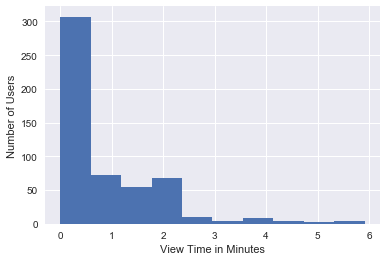

In [93]:
new_df = df[df["time_spent_mins"] <= 10]
plot = plt.hist(new_df["time_spent_mins"])
plt.xlabel("View Time in Minutes")
plt.ylabel("Number of Users")
#plt.boxplot(new_df["time_spent_mins"])

# len(new_df) 
# 1917 (22% reduced)
#sns.distplot(new_df["time_spent_mins"], color="g")

# SHARE DATA ANALYSIS

In [41]:
share_df = df[df.activity_type == "SHARE"]
share_df.columns

Index([u'activity_type', u'user_id', u'rm_id', u'viewing_device', u'browser',
       u'user_groups', u'shared_date', u'shared_time', u'title_of_content',
       u'share_channel', u'viewed', u'time_spent_in_seconds',
       u'last_activity_date', u'last_activity_time', u'weekday',
       u'weekday_name', u'month', u'time_of_day', u'hour', u'time_spent_mins'],
      dtype='object')

In [42]:
y_time_spent = share_df.groupby("weekday")["time_spent_mins"].sum

In [43]:
#sns.stripplot(x=share_df["weekday_name"], y=share_df["time_spent_mins"], data=share_df, jitter=True)

In [44]:
len(share_df), len(share_df.user_id.unique())

(140, 100)

In [45]:
share_df['num_of_day_from_share_view'] = (share_df["last_activity_date"] - share_df["shared_date"]).astype(dt.timedelta).map(lambda x: 0 if pd.isnull(x) else x.days)
share_df["num_of_day_from_share_view"].unique()

# sns.distplot(share_df["num_of_day_from_share_view"], color="m")

/Users/urmimukherjee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([ 0,  1,  7,  5, 14,  4,  2])

(array([ 0.68367347,  0.00510204,  0.00510204,  0.00510204,  0.        ,
         0.00510204,  0.        ,  0.        ,  0.        ,  0.01020408]),
 array([  0. ,   1.4,   2.8,   4.2,   5.6,   7. ,   8.4,   9.8,  11.2,
         12.6,  14. ]),
 <a list of 10 Patch objects>)

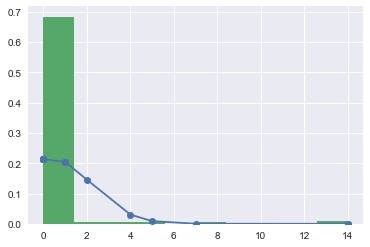

In [46]:
import pylab as pl
h = sorted(share_df["num_of_day_from_share_view"])  #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)

<module 'pylab' from '/Users/urmimukherjee/anaconda2/lib/python2.7/site-packages/pylab.pyc'>

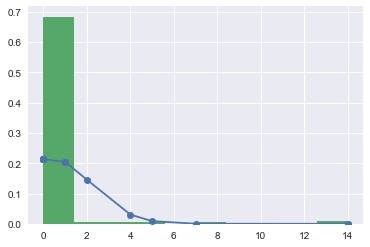

In [47]:
import pylab as pl
days_share_view = share_df[share_df["num_of_day_from_share_view"]<=100]
len(share_df),len(days_share_view)
h = sorted(days_share_view["num_of_day_from_share_view"]) #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)
pl

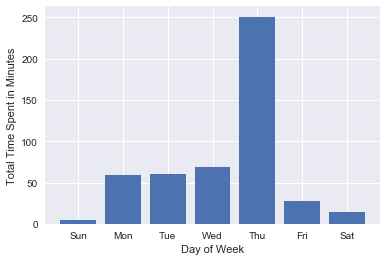

In [98]:
plt.bar(xrange(0,7), df.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.xlabel("Day of Week")
plt.ylabel("Total Time Spent in Minutes")

In [96]:
# uniq_titles = np.sort(share_df.title_of_content.unique())
# uniq_title_num_share = share_df.groupby("title_of_content")["activity_type"].count()
# #uniq_titles 
# uniq_title_num_share

In [49]:
# import pylab as pl
# h = sorted(share_df["time_spent_mins"])  #sorted

# fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

# pl.plot(h,fit,'-o')

# pl.hist(h,normed=True)


In [50]:
#share_df["weekday"].plot.kde()

In [51]:
# plot = plt.bar(xrange(0,7),(share_df.groupby("weekday")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,7),["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
# share_weekday = share_df.groupby("weekday")["time_spent_mins"].sum()

In [52]:
# plot = plt.bar(xrange(0,7),(share_df.groupby("month")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,7),["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

In [53]:
# import pylab as pl
# new_share = share_df[share_df["time_spent_mins"]<=8]
# h = sorted(new_share["time_spent_mins"])  #sorted

# fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

# pl.plot(h,fit,'-o')
# pl.axvline(x=np.mean(h)+np.std(h),color='r', linestyle='--')
# pl.axvline(x=np.mean(h)-np.std(h),color='r', linestyle='--')
# pl.hist(h,normed=True)


In [54]:
#h = plt.hist(share_df.time_spent_mins)

In [55]:
#sns.stripplot(x="share_channel", y="time_spent_mins", data=share_df)
df.share_channel.unique()


array([nan, 'ANDROID', 'IOS', 'WEB'], dtype=object)

([<matplotlib.axis.XTick at 0x11f217050>,
 <a list of 3 Text xticklabel objects>)

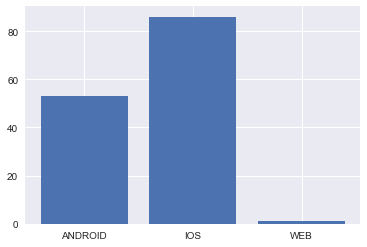

In [57]:
plt.bar(xrange(0,3),(share_df.groupby("share_channel")["time_spent_mins"].count()))
plt.xticks(xrange(0,3),["ANDROID","IOS", "WEB"])
# plt.xlabel("Share Channel")
# plt.ylabel("Number of Shares")
# plt.title("TW - Num Shares Vs Share Channel")

In [58]:
#sns.stripplot(x="time_of_day", y="time_spent_mins", data=share_df)


# VIEW DATA ANALYSIS

In [59]:
view_df = df[(df.activity_type == "VIEW")]
view_df = view_df.drop(["share_channel", "user_groups", "shared_date", "shared_time", "rm_id"], axis =1)


In [60]:
len(view_df), len(view_df.user_id.unique())

(398, 90)

In [61]:
len(view_df.title_of_content.unique())


64

In [62]:
#view_df.head()

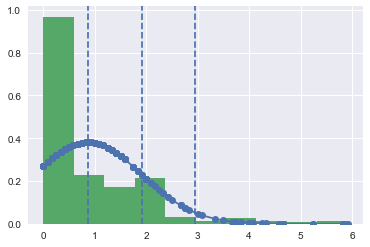

In [63]:
#### import pylab as pl
new_view = view_df[view_df["time_spent_mins"] <= 4]
len(new_view) #(20 mins, 1874/2085, 10% reduced) (12 mins, 1746/2085, 16% reduced)(6 mins, 1607/2085, 23% reduced)
# (4 mins, 1513/2085, 28% reduced)

h = sorted(new_df["time_spent_mins"])  #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h, normed= True)

pl.axvline(x = np.mean(h), linestyle='--')
pl.axvline(x = np.mean(h) + np.std(h), linestyle='--')
pl.axvline(x = np.mean(h) + 2*np.std(h), linestyle='--')


In [64]:
#(view_df.groupby("view_app_group")["time_spent_mins"].sum()).plot.kde()


(array([ 213.,   60.,   34.,   66.,    9.,    2.,    8.,    4.,    1.,    1.]),
 array([ 0.        ,  0.58333333,  1.16666667,  1.75      ,  2.33333333,
         2.91666667,  3.5       ,  4.08333333,  4.66666667,  5.25      ,
         5.83333333]),
 <a list of 10 Patch objects>)

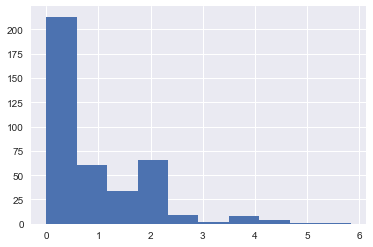

In [65]:
plt.hist(view_df["time_spent_mins"])

In [91]:
from collections import Counter
user_id_list = [j.user_id for i,j in df.iterrows() if j["activity_type"] == "VIEW"]
num_views = Counter(user_id_list)
best, views = [], []
#best = sorted(num_views, key=lambda x : num_views[x])
for w in sorted(num_views, key=num_views.get, reverse=True):
    best.extend([w, num_views[w]]), views.append(num_views[w])
np.array(views).mean(), np.array(views).std()

(4.4222222222222225, 6.0936720871878931)

(array([ 43.,   8.,   7.,  10.,   1.,   1.,   2.,   1.,   3.,   0.,   1.,
          2.,   3.,   1.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ,  10.9,  11.8,  12.7,  13.6,  14.5,  15.4,  16.3,
         17.2,  18.1,  19. ,  19.9,  20.8,  21.7,  22.6,  23.5,  24.4,
         25.3,  26.2,  27.1,  28. ,  28.9,  29.8,  30.7,  31.6,  32.5,
         33.4,  34.3,  35.2,  36.1,  37. ]),
 <a list of 40 Patch objects>)

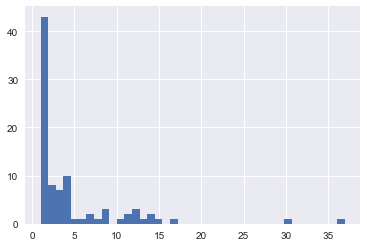

In [89]:
plt.hist(views, bins= 40)

In [66]:
sorted(view_df.browser.unique())

[nan, 'CHROME', 'CHROME_MOBILE', 'MOBILE_SAFARI', 'SAFARI']

([<matplotlib.axis.XTick at 0x11f5a97d0>,
 <a list of 4 Text xticklabel objects>)

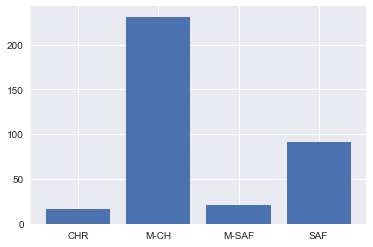

In [67]:
plt.bar(xrange(0,len(view_df.groupby("browser")["time_spent_mins"].sum())), view_df.groupby("browser")["time_spent_mins"].sum())
plt.xticks(xrange(0,4),['CHR',"M-CH",'M-SAF','SAF'])
# plt.xlabel("Viewing Application")
# plt.ylabel("Total View Time in Minutes")
# plt.title("Time Spent Vs View App")

([<matplotlib.axis.XTick at 0x11fd3cb10>,
 <a list of 4 Text xticklabel objects>)

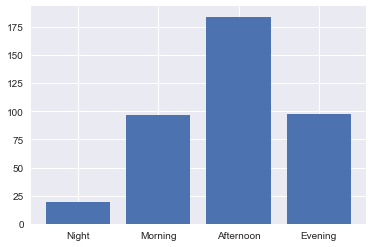

In [86]:
plt.bar(xrange(0,4), view_df.groupby("time_of_day")["time_spent_mins"].count())
plt.xticks(xrange(0,4),["Night", "Morning", "Afternoon", "Evening"])
# plt.xlabel("Time of Day")
# plt.ylabel("Total View Time in Minutes")
# plt.title("TW - Time Spent Vs Time of Day")

In [69]:
def get_view_time_per_user(unique_users, view_df):
    for user in unique_users:
        temp_time = view_df["user_id"]

([<matplotlib.axis.XTick at 0x11f1fad50>,
 <a list of 7 Text xticklabel objects>)

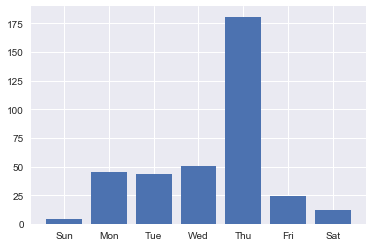

In [70]:
plt.bar(xrange(0,7), view_df.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
#plt.xlabel("Day of Week")
#plt.ylabel("Total View Time in Minutes")
#plt.title("TW - Time Spent Vs Day of Week")

In [71]:
# Get the time spent on different apps
# def get_time_spent(view_df):
#     time_spent_secs = view_df["time_spent_in_seconds"].sum()
#     view_apps = view_df["view_app_group"].unique()

#     time_spent_dict = {}
#     for v in view_apps:
#         temp_time = view_df[view_df.view_app_group == v]["time_spent_in_seconds"].sum()
#         time_spent_dict[v] = [temp_time, float(temp_time)*100/time_spent_secs]
#     return time_spent_dict

# get_time_spent(view_df)

([<matplotlib.axis.XTick at 0x11f8b9890>,
 <a list of 2 Text xticklabel objects>)

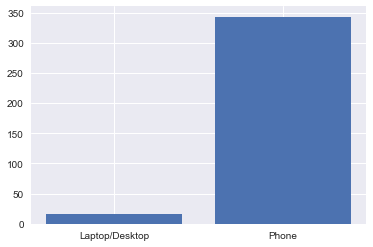

In [73]:
plt.bar(xrange(0,2), view_df.groupby("viewing_device")["time_spent_mins"].sum())
plt.xticks(xrange(0,2),["Laptop/Desktop", "Phone"])

In [74]:
#sns.stripplot(x="view_app_group", y="time_spent_mins", data=view_df)
#plt.bar(xrange(0,8), view_df.groupby("view_app_group")["time_spent_mins"].sum())

In [75]:
#sns.boxplot(x="view_app_group", y="time_spent_mins", data=view_df, hue = "view_app_group")


In [76]:
#sns.barplot(x="view_app_group", y="time_spent_mins", data=view_df, hue = "view_app_group")


In [77]:
#sns.countplot(x="view_app_group", data=view_df, hue = "view_app_group")


In [78]:
#plt.bar(xrange(0,9),view_df.groupby("view_app_group")["time_spent_mins"].sum())

In [79]:
#sns.stripplot(x=view_df["view_app_group"], y=view_df["time_spent_mins"], data=view_df, jitter=True)


In [80]:
#sns.stripplot(x=view_df["weekday"], y=view_df["time_spent_mins"], data=view_df, jitter=True)



([<matplotlib.axis.XTick at 0x11fb1d510>,
 <a list of 3 Text xticklabel objects>)

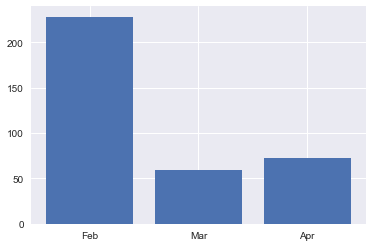

In [83]:
plt.bar(xrange(0,len(view_df.groupby("month")["time_spent_mins"].sum())), view_df.groupby("month")["time_spent_mins"].sum())
plt.xticks(xrange(0,3),["Feb", "Mar", "Apr"])

In [82]:
# clusterer = KMeans(n_clusters=7, random_state=10)
# clusterer.fit(X)

